## Choropleth drawing in Bokeh/Matplotlib with geopandas

links

* https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
* https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0
* https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
* https://ourworldindata.org/
* https://github.com/owid/owid-datasets
* [GIS at UCD and on the Web: Find Spatial Data & Other Datasets for Ireland](https://libguides.ucd.ie/gisguide/FindSpatialData)
* [Townlands.ie](https://www.townlands.ie/page/download/)

In [91]:
import pandas as pd
import geopandas as gpd
import json
import matplotlib as mpl
import pylab as plt

from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer

import panel as pn
import panel.widgets as pnw
pn.extension()
output_notebook()

Loading BokehJS ...

## read shape file

In [7]:
shapefile = 'data/ne_110m_admin_0_countries.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])

## read data

In [56]:
owid = pd.read_csv('data/owid.csv').set_index('name')
print (owid)
def get_dataset(name,key=None,year=None):
    
    url = owid.loc[name].url
    df = pd.read_csv(url)
    if year is not None:
        df = df[df['Year'] == year]
    #Merge dataframes gdf and df_2016.
    if key is None:
        key = df.columns[2]
    merged = gdf.merge(df, left_on = 'country', right_on = 'Entity', how = 'left')
    merged[key] = merged[key].fillna(0)    
    return merged, key

#get_dataset('Literate world population')

                                                                                     url
name                                                                                    
Annual CO2 emissions                   https://raw.githubusercontent.com/owid/owid-da...
Land surface temperature anomaly       https://raw.githubusercontent.com/owid/owid-da...
Number of polio cases per one million  https://raw.githubusercontent.com/owid/owid-da...


## plot with matplotlib

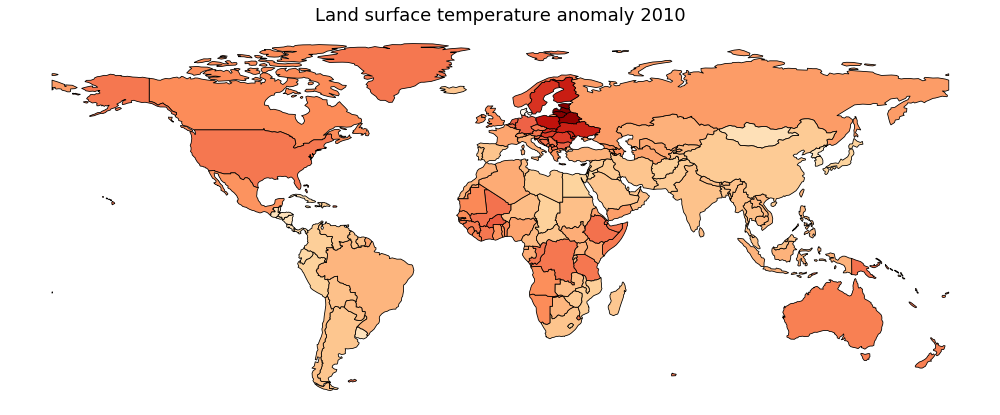

In [87]:
datasetname='Land surface temperature anomaly'
df,key = get_dataset(datasetname, year=2010)
fig, ax = plt.subplots(1, figsize=(14, 8))
df.plot(column=key, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='black')
ax.axis('off')
ax.set_title('%s 2010' %datasetname, fontsize=18)
plt.tight_layout()
plt.savefig('test_map.png',dpi=150)


## plot with bokeh

### json data

In [10]:
def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

In [89]:
def bokeh_plot_map(gdf, column=None, title=''):
    """Plot bokeh map from GeoJSONDataSource """
    
    geosource = get_geodatasource(gdf)
    palette = brewer['OrRd'][8]
    palette = palette[::-1]
    vals = gdf[column]
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = vals.min(), high = vals.max())
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20, 
                         location=(0,0), orientation='horizontal')

    tools = 'wheel_zoom,pan,reset'
    p = figure(title = title, plot_height=400 , plot_width=850, toolbar_location='right', tools=tools)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    #Add patch renderer to figure
    p.patches('xs','ys', source=geosource, fill_alpha=1, line_width=0.5, line_color='black',  
              fill_color={'field' :column , 'transform': color_mapper})
    #Specify figure layout.
    p.add_layout(color_bar, 'below')
    return p

p = bokeh_plot_map(df, key, title=datasetname)
#export_png(p, filename="plot.png")
pn.pane.Bokeh(p)

Bokeh(Figure)

In [90]:
def map_dash():
    """Map dashboard"""
    
    from bokeh.models.widgets import DataTable
    map_pane = pn.pane.Bokeh(width=400)
    data_select = pnw.Select(name='dataset',options=list(owid.index))
    year_slider = pnw.IntSlider(start=1950,end=2018,value=2010)
    def update_map(event):
        gdf,key = get_dataset(name=data_select.value,year=year_slider.value)        
        map_pane.object = bokeh_plot_map(gdf, key)        
        return
    year_slider.param.watch(update_map,'value')
    year_slider.param.trigger('value')
    data_select.param.watch(update_map,'value')
    app = pn.Column(pn.Row(data_select,year_slider),map_pane)
    return app

app = map_dash()
app

Column
    [0] Row
        [0] Select(name='dataset', options=['Annual CO2 emissions', ...], value='Annual CO2 emissions')
        [1] IntSlider(end=2018, start=1950, value=2010)
    [1] Bokeh(Figure, width=400)